# HW03: Distance and Topic Model

Remember that these homework work as a completion grade. **You can skip one section without losing credit.**

## Load and Pre-process Text

In [1]:
#Import the AG news dataset (same as hw01)
#Download them from here 
#!wget https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import nltk
df = pd.read_csv('train.csv')

df.columns = ["label", "title", "lead"]
label_map = {1:"world", 2:"sport", 3:"business", 4:"sci/tech"}
def replace_label(x):
	return label_map[x]
df["label"] = df["label"].apply(replace_label) 
df["text"] = df["title"] + " " + df["lead"]
df.head()

,label,title,lead,text
0,business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...
1,business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...
2,business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...
3,business,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","Oil prices soar to all-time record, posing new..."
4,business,"Stocks End Up, But Near Year Lows (Reuters)",Reuters - Stocks ended slightly higher on Frid...,"Stocks End Up, But Near Year Lows (Reuters) Re..."


In [2]:
import spacy
dfs = df.sample(200)
nlp = spacy.load('en_core_web_sm')
from sklearn.feature_extraction.text import CountVectorizer

##TODO pre-process text as you did in HW02
import spacy
nlp = spacy.load('en_core_web_sm')
def tokenize(x):
    return [w.lemma_.lower() for w in nlp(x) if not w.is_stop and not w.is_punct and not w.is_digit]
dfs["tokens"] = dfs["text"].apply(lambda x: tokenize(x))
dfs["preprocessed"] = dfs['tokens'].apply(lambda x: ' '.join(x))
##TODO vectorize the pre-processed text using CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(min_df=0.01, # at min 1% of docs
                        max_df=.9,  
                        max_features=1000,
                        stop_words='english',
                        ngram_range=(1,3))
X = vec.fit_transform(dfs['preprocessed']).toarray()

## Cosine Similarity and PCA

In [3]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

##TODO compute the cosine similarity for the first 200 snippets and show the similatrity scores for the first document
sim = cosine_similarity(X)

text1 = sim[0]
text1 = sorted(text1, reverse=True)
doc_num = int(np.where(sim[0]==text1[1])[0])
print(dfs.iloc[0]['text'])
print(' ')
print(dfs.iloc[doc_num]['text'])

U.S. Official: No Prospect of Bargain on Iran Nukes (Reuters) Reuters - The United States sees no reason to\offer Iran incentives to ensure its nuclear program remains\peaceful, a U.S. government official said on Tuesday.
 
Saddam Told Interrogators of Iran Fixation WASHINGTON - Saddam Hussein was obsessed with his status in the Arab world, dreaming of weapons of mass destruction to pump up his prestige. And even as the United States fixated on him, he was fixated on his neighboring enemy, Iran...


In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3,svd_solver='randomized')

##TODO reduce the data using PCA
Xpca = pca.fit_transform(X)

##TODO compute the cosine similarity with the reduced data
sim_pca = cosine_similarity(Xpca)

sim[0][:10], sim_pca[0][:10]

(array([1.        , 0.05897678, 0.04364358, 0.        , 0.        ,
        0.        , 0.17457431, 0.        , 0.        , 0.11094004]),
 array([ 1.        , -0.6535737 ,  0.57312749, -0.55511102,  0.34821877,
         0.39366938,  0.6147464 ,  0.34145716, -0.91711227,  0.63979268]))

In [5]:
text1 = sim_pca[0]
text1 = sorted(text1, reverse=True)
doc_num = int(np.where(sim_pca[0]==text1[1])[0])
print(dfs.iloc[0]['text'])
print(' ')
print(dfs.iloc[doc_num]['text'])

U.S. Official: No Prospect of Bargain on Iran Nukes (Reuters) Reuters - The United States sees no reason to\offer Iran incentives to ensure its nuclear program remains\peaceful, a U.S. government official said on Tuesday.
 
Disaster Toll Tripled in 2003 Amid Quakes, Heatwave (Reuters) Reuters - Natural disasters killed 76,806 people\in 2003, three times the number of victims in 2002, a rise due\in part to extremes in the global climate, the world's largest\humanitarian body said on Thursday.


Compare the cosine similarity before and after PCA reduction. Did the results change? 

## Clustering

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

##TODO create the clusters found with k-means clustering and 10 clusters
km = KMeans(n_clusters=10)
km.fit(X)
doc_clusters = km.labels_.tolist()
dfs['cluster'] = doc_clusters
dfs[dfs['cluster']==1][['label','text']]

,label,text
69444,sport,This Date in Baseball for Oct. 23 (AP) AP - 19...
49655,sport,Healthy Iverson Vows Changes This Season (AP) ...
72866,world,"Svenska Cellulosa to Slash 1,200 Jobs (AP) AP ..."
5220,sport,Golfer Thatcher Leads at Reno-Tahoe Open (AP) ...
111633,sport,Eagles' Westbrook Turning Into Elite Back (AP)...
49958,world,Supreme Court OKs Calif. Gun Show Bans (AP) AP...
98144,sport,Injuries Deplete Rams Defensive Secondary (AP)...
102727,sport,Chargers Confident Going Into Jets Rematch (AP...
102872,world,Poll: Blair Retains Electoral Lead (AP) AP - P...
64856,world,"Israel, Egypt Move Toward Warm Relations (AP) ..."


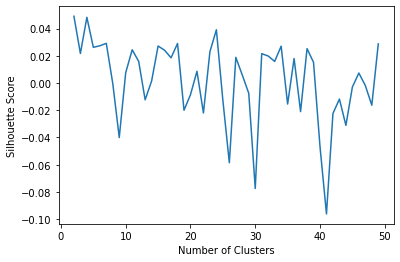

The optimal number of clusters is 4


In [7]:
##TODO find the optimal number of clusters in a range from 2 to 50 using the silhouette score

sil_scores = []
for n in range(2, 50):
    km = KMeans(n_clusters=n)
    km.fit(X)
    sil_scores.append(silhouette_score(X, km.labels_))

import matplotlib.pyplot as plt 
plt.plot(range(2, 50), sil_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

opt_sil_score = max(sil_scores[2:])
sil_scores.index(opt_sil_score)
opt_num_cluster = range(2, 50)[sil_scores.index(opt_sil_score)]
print('The optimal number of clusters is %s' %opt_num_cluster)

In [8]:
##TODO create the clusters using the opitmal number of clusters obtained before
##TODO compare the documents in cluster 1 under the two specifications
km = KMeans(n_clusters=opt_num_cluster)
km.fit(X)
doc_clusters = km.labels_.tolist()

dfs['cluster_opt'] = doc_clusters
dfs[dfs['cluster_opt']==1][['label','text']]


,label,text
5020,world,Stocks Up Despite Oil Nearing \$50 a Barrel NE...
90253,sport,"Aggies won't be outgunned COLLEGE STATION, Tex..."
54080,business,Melnyk steps aside at Biovail Billionaire Euge...
63997,business,Oil Prices Slide After Posting New High Oil pr...
64019,business,Marsh amp; McLennan plummets as market run sc...
94403,business,Column: Cheaper Oil Fuels Stocks Rally NEW YO...


## Topic Modeling: LDA

For this part you will need to use LDA Mallet. If you cannot have Mallet run, you can use the simple LDA algorithm 

In [9]:
from gensim.corpora import Dictionary
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel

##TODO create a dictionary with the pre-processed tokenized text and filter it according to frequencies and keeping 1000 vocabularies
from gensim import corpora
dictionary = corpora.Dictionary(dfs['tokens'])
print (len(dictionary))
##TODO create the doc_term_matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in dfs['tokens']]

2394


In [10]:
##TODO train a LDA Mallet model with 5, 10 and 15 topics
##TODO compute the coherence score for each of these model and print the number of topics from the model with highest coherence score
#mallet_path = '/home/cmarangon/mallet-2.0.8/bin/mallet'
mallet_path = 'mallet-2.0.8/bin/mallet'

scores = []
for num_topics in [5, 10, 15]:
    lda = LdaMallet(mallet_path, doc_term_matrix, num_topics=num_topics, id2word=dictionary)
    coherence = CoherenceModel(model=lda, texts=dfs['tokens'], corpus=doc_term_matrix, dictionary=dictionary, coherence='c_v')
    scores.append((num_topics, coherence.get_coherence()))
df_topic = pd.DataFrame(scores, columns=["Number of Topics", "Coherence Scores"])
df_topic.head()

,Number of Topics,Coherence Scores
0,5,0.549539
1,10,0.569568
2,15,0.594188


In [11]:
opt_topics = int(df_topic.iloc[df_topic['Coherence Scores'].idxmax()]['Number of Topics'])
print('The optimal number of topics is: %s' %opt_topics)

The optimal number of topics is: 15


In [12]:
import pyLDAvis.gensim
from gensim.models import wrappers

##TODO using LDAvis visualize the topics using the optimal number of topics

lda = LdaMallet(mallet_path, doc_term_matrix, num_topics=opt_topics, id2word=dictionary)
lda_vis = wrappers.ldamallet.malletmodel2ldamodel(lda)

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_vis, doc_term_matrix, dictionary)



PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
8     -0.038655  0.105866       1        1  6.883319
12    -0.077154  0.140355       2        1  6.835360
14     0.075718  0.094451       3        1  6.827915
3      0.083850 -0.056895       4        1  6.820114
4     -0.129179  0.120174       5        1  6.755510
6     -0.055124 -0.084621       6        1  6.743228
11    -0.041704  0.093785       7        1  6.715126
0     -0.167003 -0.160430       8        1  6.684067
13     0.282002 -0.098172       9        1  6.664558
2     -0.110707 -0.240067      10        1  6.655952
7     -0.013823  0.076690      11        1  6.646082
10    -0.124611 -0.183634      12        1  6.577484
9      0.291474 -0.084280      13        1  6.427856
5      0.045278  0.152421      14        1  6.384537
1     -0.020363  0.124357      15        1  6.378890, topic_info=         Term       Freq      Total Category  logprob  loglift
21       39;s  58.000000  58.000000  Default  30.0000  30.0000
12    reuters  37.000000  37.000000  Default  29.0000  29.0000
97         ap  32.000000  32.000000  Default  28.0000  28.0000
453       oil  23.000000  23.000000  Default  27.0000  27.0000
444   company  22.000000  22.000000  Default  26.0000  26.0000
...       ...        ...        ...      ...      ...      ...
2287   regime   2.311577   2.311577  Topic15  -4.9016   2.7522
1631    stall   2.311577   2.311577  Topic15  -4.9016   2.7522
1885  chipper   2.311577   2.311577  Topic15  -4.9016   2.7522
558     delay   3.467366   4.493109  Topic15  -4.4961   2.4930
156      late   3.467366   4.607228  Topic15  -4.4961   2.4679

[967 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
20        9  0.749361  &lt;/b&gt
20       13  0.187340  &lt;/b&gt
1022     11  0.907603  -bernanke
534       8  0.899376      1,200
1351      5  0.974903        1.3
...     ...       ...        ...
96       12  0.269439  yesterday
428       8  0.981137       york
1328      4  0.977701  youngster
1315     13  0.852235   zangeneh
2282      3  0.979589       ziff

[1021 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 13, 15, 4, 5, 7, 12, 1, 14, 3, 8, 11, 10, 6, 2])